# Полносвязная нейронная сеть для определения пиков

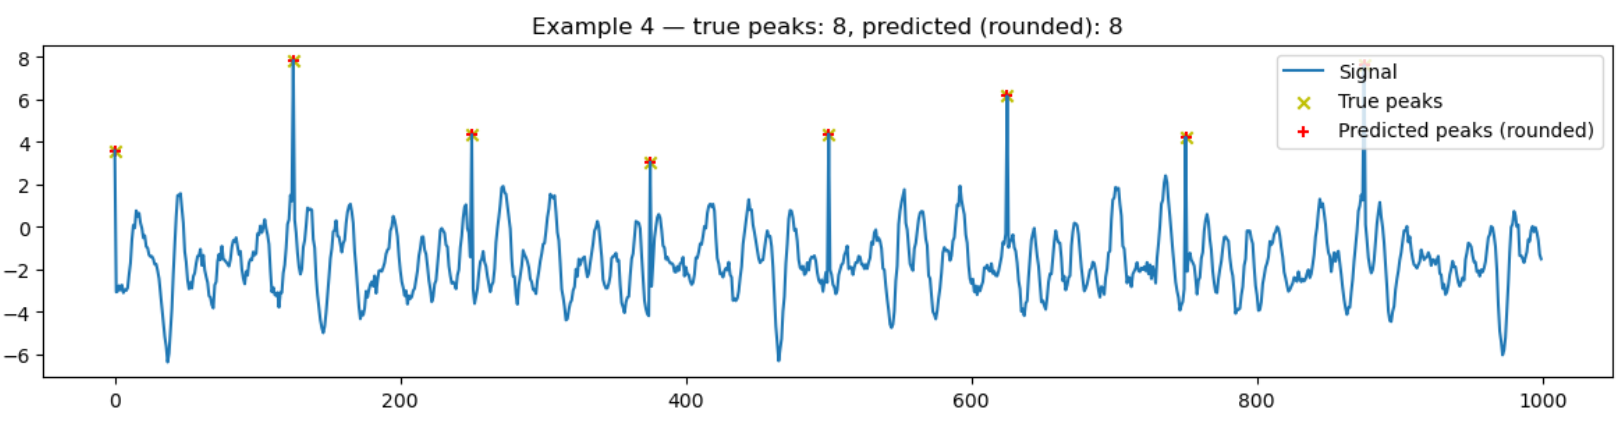

Исследуется сигнал, имеющий вид суммы гармонических функций с наложенным шумом. Для удобства сигнал дискретизирован в виде набора из 1000 точек. Пиком называется точка, в которой значение в несколько раз превосходит значения в соседних точках. Опыт показывает, что функция scipy.signal.find_peaks не всегда правильно классифицирует пики, поэтому предлагается искать их с помощью полносвязной нейронной сети.

## 1. Генерация датасета для обучения

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
import os


def generate_signal(length: int = 1000) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates a synthetic signal composed of multiple sinusoidal components 
    and adds random noise to it. The function also creates a mask indicating 
    the positions of the peaks in the signal.

    Parameters:
    length (int): The number of data points in the generated signal. Default is 1000.

    Returns:
    tuple[np.ndarray, np.ndarray]: A tuple containing two numpy arrays:
        - The first array is the generated signal with added noise and peaks.
        - The second array is a mask of the same length, where 1.0 indicates 
          the positions of the peaks and 0.0 indicates non-peak positions.
    """
    
    x = np.linspace(0, 10, length)
    num_sinusoids = np.random.randint(3, 10)
    signal = np.zeros_like(x)
    
    for _ in range(num_sinusoids):
        a = np.random.uniform(-1, 1)
        b = np.random.uniform(0.05, 1)
        c = np.random.uniform(0.5, 10) * 2 * np.pi
        d = np.random.uniform(0, 2 * np.pi)
        signal += a + b * np.sin(c * x + d)
        
    noise = np.random.randn(length) * 0.2
    signal += noise
    max_signal = np.max(np.abs(signal))
    peak_value = np.random.uniform(0.2, 3) * max_signal
    num_peaks = np.random.randint(5, 30)
    step = length // num_peaks
    peak_positions = np.arange(0, length, step)[:num_peaks]
    signal[peak_positions] += peak_value

    mask = np.zeros(length, dtype=np.float32)
    mask[peak_positions] = 1.0

    return signal.astype(np.float32), mask


def build_and_save_dataset(
    filename: str = "signals_dataset.npz", 
    num_samples: int = 2000, 
    length: int = 1000
) -> None:
    """
    Builds a dataset of synthetic signals by generating multiple samples 
    using the generate_signal function and saves the dataset to a compressed 
    .npz file.

    Parameters:
    filename (str): The name of the file where the dataset will be saved. 
                    Default is "signals_dataset.npz".
    num_samples (int): The number of signal samples to generate. Default is 2000.
    length (int): The length of each generated signal. Default is 1000.

    Returns:
    None: This function does not return any value. It saves the generated 
          signals and their corresponding masks to the specified file.
    """
    
    signals = np.zeros((num_samples, length), dtype=np.float32)
    masks = np.zeros((num_samples, length), dtype=np.float32)
    
    for i in range(num_samples):
        s, m = generate_signal(length=length)
        signals[i] = s
        masks[i] = m
        
    np.savez_compressed(filename, signals=signals, masks=masks)

# Generating and saving a dataset with 2000 instances of signals 
dataset_path = "signals_dataset.npz"
if not os.path.exists(dataset_path):
    build_and_save_dataset(filename=dataset_path, num_samples=2000, length=1000)
else:
    print(f"{dataset_path} already exists, skip generation")


signals_dataset.npz already exists, skip generation


## 2. Загрузка датасета

In [41]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import activations
from keras.losses import MeanSquaredError
from keras.optimizers import Adam


def load_dataset(filename: str = "signals_dataset.npz") -> tuple[np.ndarray, np.ndarray]:
    data = np.load(filename)
    signals = data["signals"].astype(np.float32)
    masks = data["masks"].astype(np.float32)
    return signals, masks


def create_model(input_dim: int = 1000) -> Sequential:
    """
    Constructs a neural network model for processing input signals.

    The model consists of:
    - Dense layers with 'tanh' activation for capturing complex patterns.
    - A final Dense layer with 'sigmoid' activation to output normalized values 
      suitable for signal reconstruction.
    - The number of neurons decreases in each layer to progressively reduce 
      complexity while retaining essential features, preventing overfitting.

    Parameters:
    input_dim (int): Dimensionality of the input data. Default is 1000.

    Returns:
    Sequential: A compiled Sequential model ready for training.
    """
    model = Sequential([
        Dense(1024, activation=activations.tanh, input_shape=(input_dim,)),
        Dense(512, activation=activations.tanh),
        Dense(256, activation=activations.tanh),
        Dense(input_dim, activation=activations.sigmoid)
    ])
    return model

# Loading the dataset
signals, masks = load_dataset("signals_dataset.npz")
X_train, X_test, y_train, y_test = train_test_split(signals, masks, test_size=0.25, random_state=0)

## 3. Инициализация и обучение полносвязной нейронной сети

In [47]:
# Creating a model
model = create_model(input_dim=X_train.shape[1])
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-3), metrics=["mse"])
model.summary()

# Fitting
history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_split=0.1, verbose=2)

# Predicting
y_pred = model.predict(X_test)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 1024)                │       1,025,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1000)                │         257,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,938,152 (7.39 MB)

 Trainable params: 1,938,152 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
22/22 - 3s - 143ms/step - loss: 0.1253 - mse: 0.1253 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 2/60
22/22 - 1s - 32ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 3/60
22/22 - 1s - 35ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 4/60
22/22 - 1s - 32ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 5/60
22/22 - 1s - 32ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 6/60
22/22 - 1s - 30ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 7/60
22/22 - 1s - 31ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 8/60
22/22 - 1s - 31ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0192 - val_mse: 0.0192
Epoch 9/60
22/22 - 1s - 30ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 10/60
22/22 - 1s - 32ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0202 - val_mse: 0.020

In [49]:

# Estimating the MSE
y_pred_rounded = np.round(y_pred)
mse_rounded = np.mean((y_pred_rounded - y_test) ** 2)

print(f"MSE (rounded 0/1 predictions vs binary mask): {mse_rounded:.6f}")

MSE (rounded 0/1 predictions vs binary mask): 0.002730


## 4. Визуализация

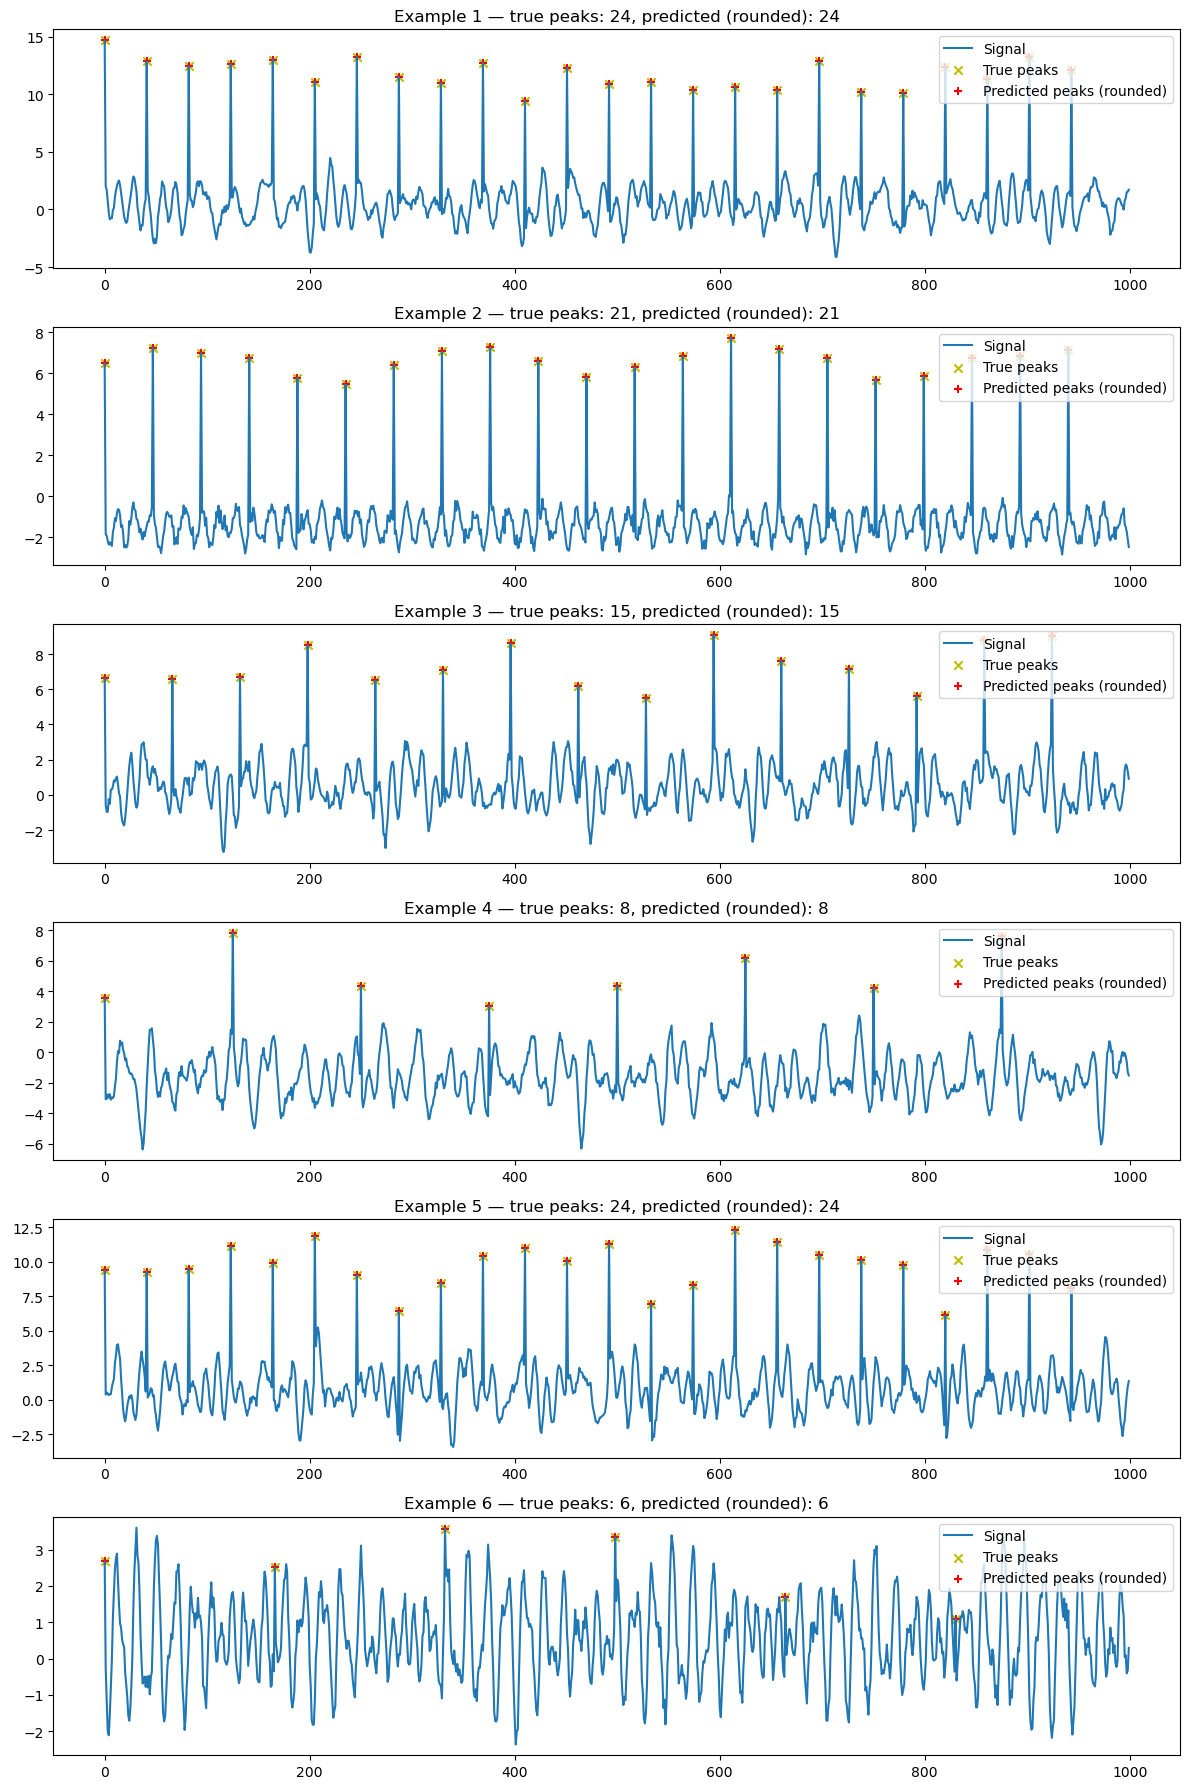

Model saved to signal_model.keras
Weights saved to signal_model_weights.weights.h5


In [55]:
num_examples = 6
indices = np.random.choice(len(X_test), num_examples, replace=False)

plt.figure(figsize=(12, 3 * num_examples))
for i, idx in enumerate(indices):
    sig = X_test[idx]
    true_mask = y_test[idx]
    pred_bin = y_pred_rounded[idx]
    plt.subplot(num_examples, 1, i + 1)
    plt.plot(sig, label="Signal")
    plt.scatter(np.where(true_mask > 0.5)[0], sig[true_mask > 0.5], marker="x", facecolors='y', label="True peaks")
    plt.scatter(np.where(pred_bin > 0.5)[0], sig[pred_bin > 0.5], marker="+", facecolors='r', label="Predicted peaks (rounded)")
    plt.legend(loc="upper right")
    plt.title(f"Example {i+1} — true peaks: {int(true_mask.sum())}, predicted (rounded): {int(pred_bin.sum())}")
plt.tight_layout()
plt.show()

model.save("signal_model.keras") 
model.save_weights("signal_model_weights.weights.h5")
print("Model saved to signal_model.keras")
print("Weights saved to signal_model_weights.weights.h5")